# import 

In [95]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Define some Functions

`-` 활성화 함수들

In [96]:
sig = torch.nn.Sigmoid()
soft = torch.nn.Softmax(dim=1)
tanh = torch.nn.Tanh() ## 시그모이드와 비슷하고 -1에서 1까지의 값을 가진다.

Text(0.5, 1.0, 'tanh(x)')

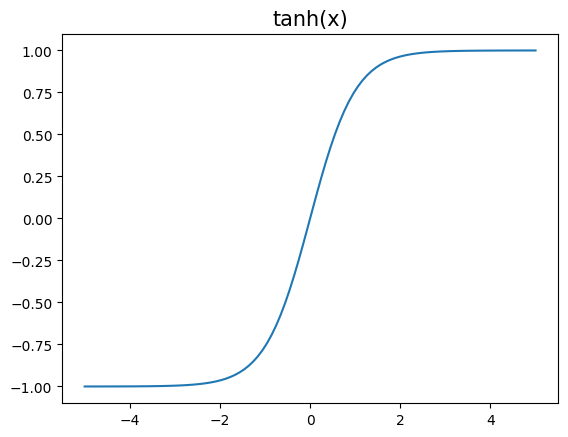

In [97]:
_x = torch.linspace(-5,5,100)
plt.plot(_x,tanh(_x))
plt.title("tanh(x)", size=15)

`-` 문자열을 숫자로 바꾸는 함수

In [98]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 

(사용예시 1)

In [99]:
txt = ['a','b','a']
mapping = {'a':33,'b':-22}
print('변환전: %s'% txt)
print('변환후: %s'% f(txt,mapping))

변환전: ['a', 'b', 'a']
변환후: [33, -22, 33]


(사용예시 2)

In [100]:
txt = ['a','b','a']
mapping = {'a':[1,0],'b':[0,1]}
print('변환전: %s'% txt)
print('변환후: %s'% f(txt,mapping))

변환전: ['a', 'b', 'a']
변환후: [[1, 0], [0, 1], [1, 0]]


# Exam1 : ab


## data

`-` 다음과 같이 문자열이 주어지면 다음 단어를 예측할 수 있도록 학습 시키고 싶음

* 즉, a가들어오면 b를 뱉어내고, b가 들어가면 a를 뱉어내도록 학습시키고 싶음

In [101]:
txt = list('ab')*100
txt[:10]

['a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b']

In [102]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [103]:
len(txt_x), len(txt_y)

(199, 199)

In [104]:
txt_x[:5],txt_y[:5]

(['a', 'b', 'a', 'b', 'a'], ['b', 'a', 'b', 'a', 'b'])

## 선형모형을 이용한 풀이

### (풀이 1) 1개의 파라미터 - 실패

`-` 데이터 정리

In [105]:
x = torch.tensor(f(txt_x,{'a':0,'b':1})).float().reshape(-1,1)
y = torch.tensor(f(txt_y,{'a':0,'b':1})).float().reshape(-1,1)

In [106]:
x[:5],y[:5]

(tensor([[0.],
         [1.],
         [0.],
         [1.],
         [0.]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]]))

`-` 학습 및 결과 시각화

In [107]:
net = torch.nn.Linear(in_features=1,out_features=1,bias=False)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

In [108]:
for epoc in range(5000):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

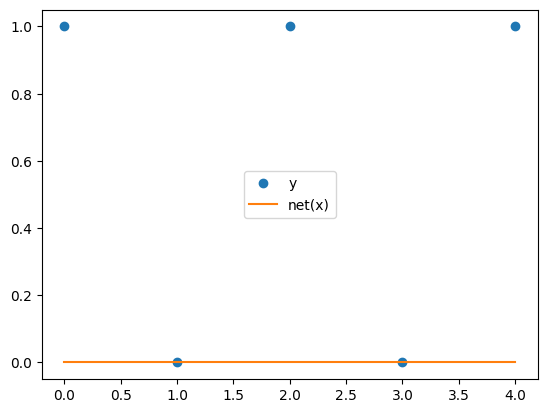

In [109]:
plt.plot(y[:5],'o')
plt.plot(net(x).data[:5])
plt.legend(["y","net(x)"])

* 학습이 잘 되지 않음.

`-` 잘 안된 이유

In [110]:
pd.DataFrame({'x':x[:5].reshape(-1),'y':y[:5].reshape(-1)})

,x,y
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0


현재 $\hat {y_i} = \hat{w}x_i$꼴의 아키텍처이고 $y_i \approx \hat {w}x_i$가 되는 적당한 $\hat {w_i}$를 찾아야 하는 상황

* $(x_i,y_i)=(0,1)$이면 어떠한 $\hat {w_i}$를 선택해도 $y_i \approx \hat {w}x_i$를 만드는 것이 불가능

* $(x_i,y_i)=(1,0)$이면 $\hat {w_i}=0$일 경우 $y_i \approx \hat {w}x_i$로 만드는 것이 가능

상황을 종합해보니 $\hat {w} = 0$으로 학습되는 것이 그나마 최선 $\to$ 와이? 그나마 절반은 맞출 수 있음.

* 그리고 $x \neq 0$으로 하면 되지않을까...??

### (풀이2) 1개의 파라메터 - 성공, but 확장성이 없는 풀이

`-` 0이라는 값이 문제가 되므로 인코딩 방식의 변경

In [111]:
x = torch.tensor(f(txt_x,{'a':-1,'b':1})).float().reshape(-1,1) 
y = torch.tensor(f(txt_y,{'a':-1,'b':1})).float().reshape(-1,1)

In [112]:
x[:5],y[:5]

(tensor([[-1.],
         [ 1.],
         [-1.],
         [ 1.],
         [-1.]]),
 tensor([[ 1.],
         [-1.],
         [ 1.],
         [-1.],
         [ 1.]]))

In [113]:
net = torch.nn.Linear(in_features=1,out_features=1,bias=False)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

In [114]:
for epoc in range(2000):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과는 성공

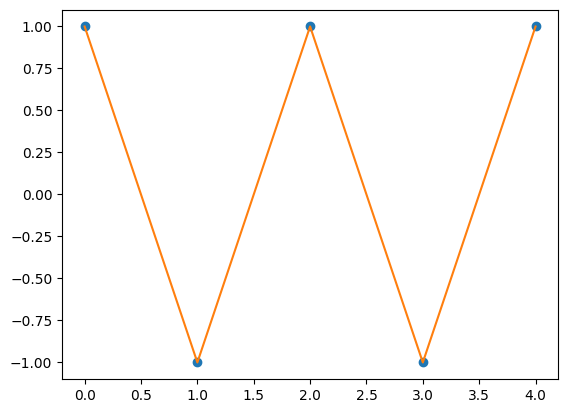

In [115]:
plt.plot(y[:5],'o')
plt.plot(net(x).data[:5])

`-` 일단 성공은 했다.

* 근데.... 이거는 다른 문제에 적용이 불가능할 것 같음. $\to$ 그리고 인코딩도 납득이 안됨.

* $a =[1,0,0], b=[0,1,0], c=[0,0,1]$ 이런식으로 바꾸고 횔성화함수를 소프트맥스를 이용해야 납득이 감

* 또한, 당연히 loss도 크로스 엔트로피를 써야함.

* 아니면 이진 분류에서 로지스틱을 쓰고, 손실함수를 binary cross entropy를 쓰면 되지 않을까...??

## 로지스틱 모형을 이용한 풀이

### (풀이 1) 1개의 파라미터 - 실패

`-` 데이터를 다시 $a=0, b=1$로 정리

In [116]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

In [117]:
x[:5],y[:5]

(tensor([[0.],
         [1.],
         [0.],
         [1.],
         [0.]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]]))

`-` 학습

In [118]:
net = torch.nn.Linear(in_features=1,out_features=1,bias=False)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())

In [119]:
for epoc in range(5000):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과

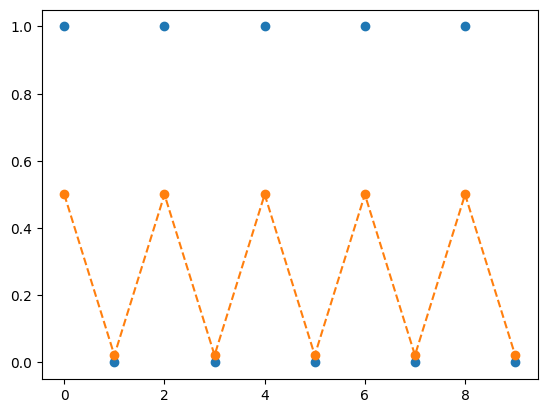

In [120]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

`-` 결과해석 : 예상되었던 실패임

*  아키텍처는 $\hat {y_i} = \text{sig}(\hat {w}x_i)$ 꼴이다.

* $(x_i,y_i) = (0,1)$ 이라면 어떠한 $\hat {w}$를 선택해도 $\hat {w}x_i=0$이다.

* 이 경우 $\hat {y_i}= \text{sig}(0)=0.5$가 된다.

* $(x_i,y_i) = (1,0)$ 이라면 $\hat {w}=-5$와 같은 큰 값으로 선택하면 $\text {sig}(-5) \approx 0 = y_i$와 같이 만들 수 있다.


In [121]:
net.weight

Parameter containing:
tensor([[-3.8163]], requires_grad=True)

### (풀이 2) 2개의 파라미터 + 좋은 초기값 - 성공

In [122]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

In [123]:
x[:5],y[:5]

(tensor([[0.],
         [1.],
         [0.],
         [1.],
         [0.]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]]))

In [124]:
net = torch.nn.Linear(in_features=1,out_features=1,bias=True)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())

In [125]:
net.weight.data = torch.tensor([[-5.00]])
net.bias.data = torch.tensor([+2.500])

`-` 학습전 결과

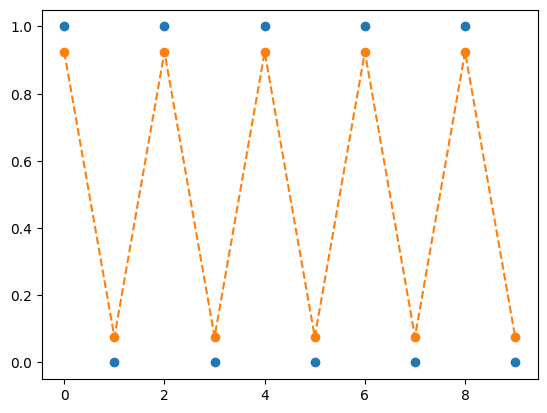

In [126]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

`-` 학습후 결과

In [127]:
for epoc in range(5000):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

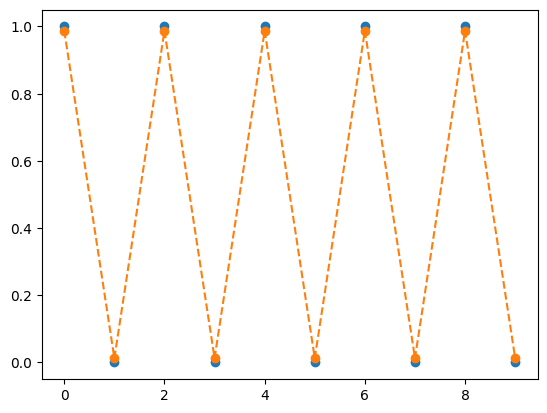

In [128]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

### (풀이3) 2개의 파라메터 + 나쁜초기값 – 성공

In [129]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

In [130]:
net = torch.nn.Linear(in_features=1,out_features=1,bias=True)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())

In [131]:
net.weight.data = torch.tensor([[+5.00]])
net.bias.data = torch.tensor([-2.500])

`-` 학습전 상태

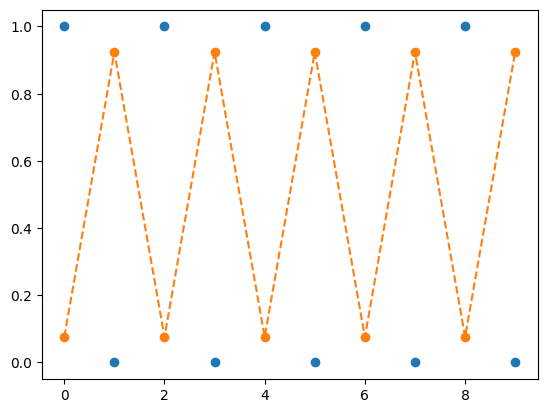

In [132]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

`-` 학습

In [133]:
for epoc in range(5000):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

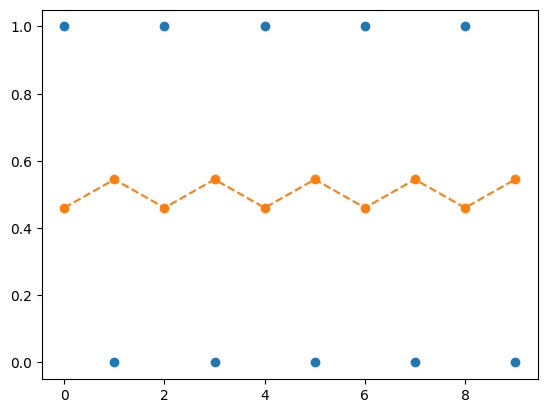

In [134]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

`-` 결국 수렴하기 할듯? $\to$ 부호를 학습하는 무언가가 있었음 좋겠어.

### (풀이4) 3개의 파라메터를 쓴다면?

In [135]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

```python
torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1,bias=True), ## 2개 파라미터
    torch.nn.ACTIVATION_FUNCTION(),
    torch.nn.Linear(in_features=1,out_features=1,bias=False) ## 1개 파라미터
)

```

`-` 위와 같은 네트워크를 설정하면 3개의 파라메터를 사용할 수 있다. 

* 적절한 ACTIVATION_FUNCTION을 골라야 하는데 실험적으로 tanh가 적절하다고 알려져있다. (그래서 우리도 실험적으로 이해해보자)

(예비학습1) net(x)와 사실 net.forward(x)는 같다.

In [137]:
net(x)[:5] # 풀이3에서 학습한 네트워크임

tensor([[-0.1584],
        [ 0.1797],
        [-0.1584],
        [ 0.1797],
        [-0.1584]], grad_fn=<SliceBackward0>)

In [138]:
net.forward(x)[:5] # 풀이3에서 학습한 네트워크임

tensor([[-0.1584],
        [ 0.1797],
        [-0.1584],
        [ 0.1797],
        [-0.1584]], grad_fn=<SliceBackward0>)

그래서 net.forward를 재정의 하면 net(x)의 기능을 재정의 할 수 있다. (오버라이딩)

In [139]:
net.forward = lambda x : 1

* “lambda x: 1” 은 입력이 x 출력이 1인 함수를 의미 (즉 입력값에 상관없이 항상 1을 출력하는 함수)

* “net.forward = lambda x:1” 이라고 새롭게 선언하였므로 앞으론 net.forward(x), net(x) 도 입력값에 상관없이 항상 1을 출력하게 될 것임

In [140]:
net(x)

1

(예비학습 2)

* torch.nn.Module을 상속받아서 네트뤄크를 만들면 (="class XXX(torch.nn.Module)")와 같은 방식으로 클래스를 선언하면?

$\to$ 약속된 아키텍처를 가진 네트워크를 찍어내는 함수를 만들 수 있다.

(예시 1) Sigmoid

In [141]:
class Mynet1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.a1 = torch.nn.Sigmoid()
        self.l2 = torch.nn.Linear(in_features=1,out_features=1,bias=False)
    def forward(self,x):        
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

이것은!

In [142]:
net = Mynet1()

아래하구 같다!!

In [143]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1,bias=True),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features=1,out_features=1,bias=False)
)

(예시 2) Relu

In [145]:
class Mynet2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.a1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(in_features=1,out_features=1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

(예시 3) Tanh

In [146]:
class Mynet3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.a1 = torch.nn.Tanh()
        self.l2 = torch.nn.Linear(in_features=1,out_features=1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

### 클래스에 대한 이해

**step1**: 아래와 코드를 복사하여 틀을 만든다. (이건 무조건 고정임, XXXX 자리는 원하는 이름을 넣는다)

```python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 사용할 레이어를 정의 
        
        ## 레이어 정의 끝
    def forward(self,x):
        ## yhat을 어떻게 구할것인지 정의 
        
        ## 정의 끝
        return yhat
```        

* net(x)에 사용하는 x임, yhat은 net.forward(x) 함수의 리턴값임

**step2** : `def __init__(self)`:에 사용할 레이어를 정의하고 이름을 붙인다. 이름은 항상 `self.xxx` 와 같은 식으로 정의한다.

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 사용할 레이어를 정의 
        self.xxx1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.xxx2 = torch.nn.Tanh()
        self.xxx3 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        ## 레이어 정의 끝
    def forward(self,x):
        ## yhat을 어떻게 구할것인지 정의 
        
        ## 정의 끝
        return yhat
```        

**step3** : `def forward` 에 `x –> yhat` 으로 가는 과정을 묘사한 코드를 작성하고 `yhat`을 리턴하도록 한다.

```python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 사용할 레이어를 정의 
        self.xxx1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.xxx2 = torch.nn.Tanh()
        self.xxx3 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        ## 레이어 정의 끝
    def forward(self,x):
        ## yhat을 어떻게 구할것인지 정의 
        u = self.xxx1(x) 
        v = self.xxx2(u)
        yhat = self.xxx3(v) 
        ## 정의 끝
        return yhat
```       

예비학습 끝

***

#### Activation : sigmoid

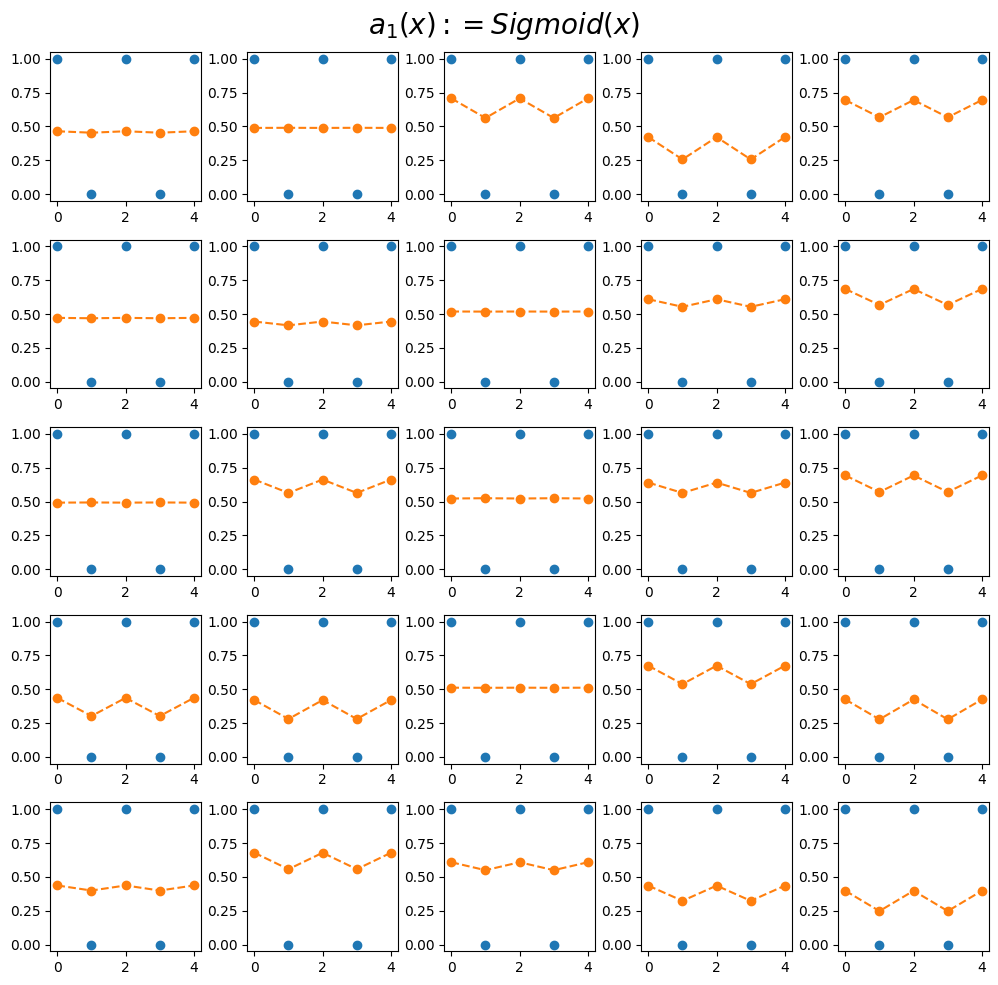

In [147]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Mynet1()
        loss_fn = torch.nn.BCEWithLogitsLoss()
        optimizr = torch.optim.Adam(net.parameters())
        for epoc in range(1000):
            ## 1
            yhat = net(x)
            ## 2
            loss = loss_fn(yhat,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        ax[i][j].plot(y[:5],'o')
        ax[i][j].plot(sig(net(x[:5])).data,'--o')
fig.suptitle(r"$a_1(x):=Sigmoid(x)$",size=20)
fig.tight_layout()

#### Activation : ReLU

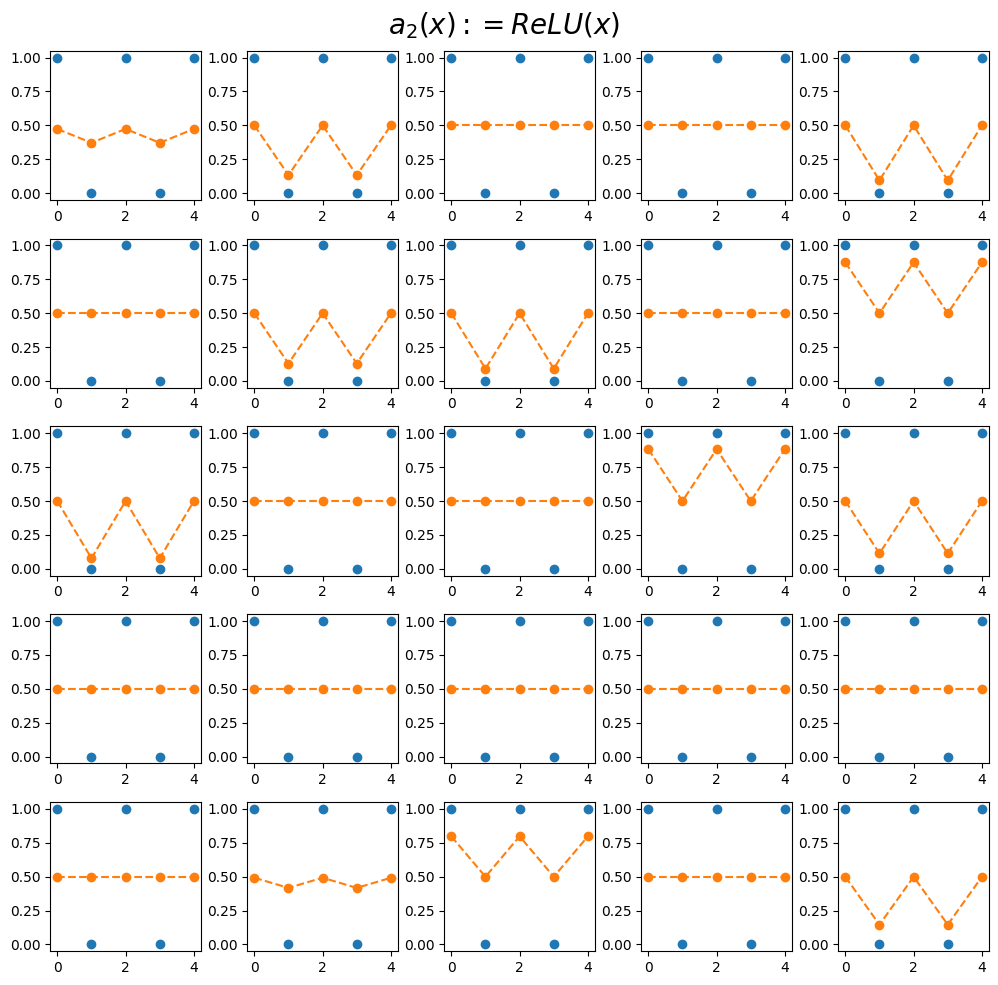

In [148]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Mynet2()
        loss_fn = torch.nn.BCEWithLogitsLoss()
        optimizr = torch.optim.Adam(net.parameters())
        for epoc in range(1000):
            ## 1
            yhat = net(x)
            ## 2
            loss = loss_fn(yhat,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        ax[i][j].plot(y[:5],'o')
        ax[i][j].plot(sig(net(x[:5])).data,'--o')
fig.suptitle(r"$a_2(x):=ReLU(x)$",size=20)
fig.tight_layout()

#### Actiovation : tanh

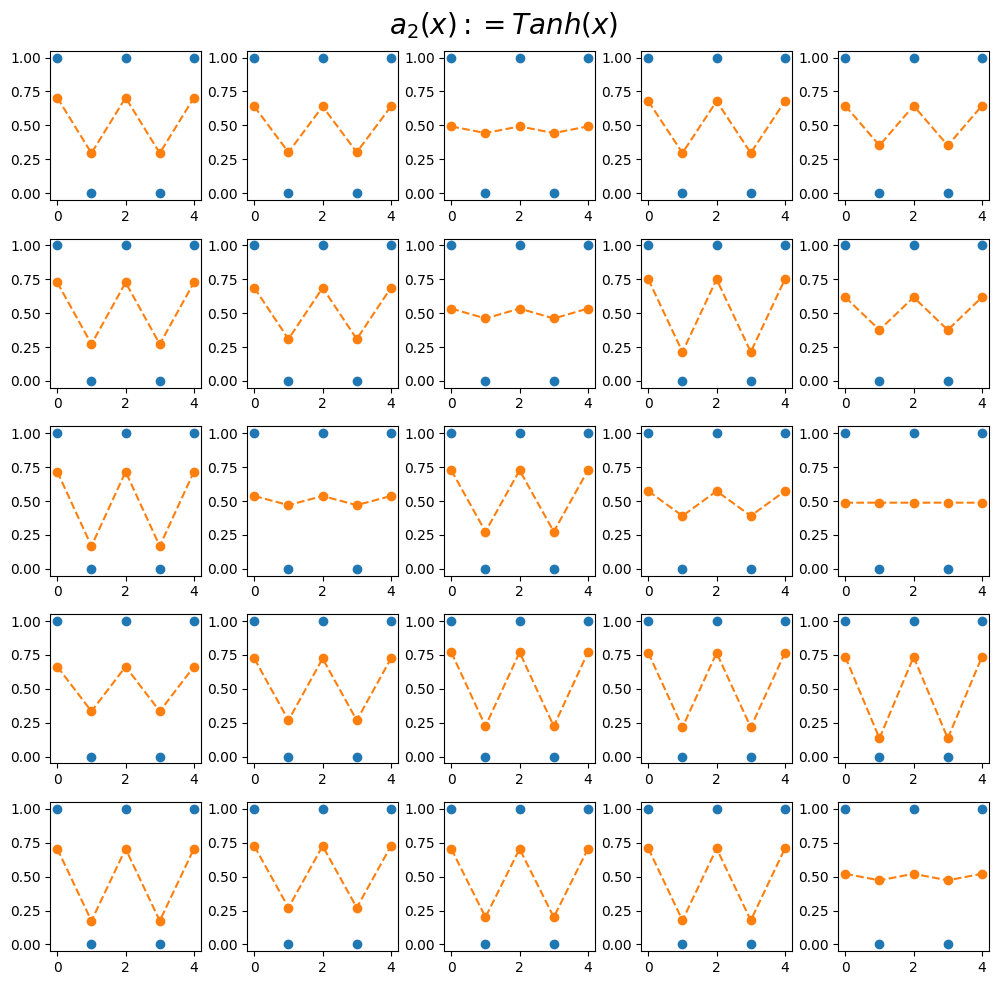

In [149]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Mynet3()
        loss_fn = torch.nn.BCEWithLogitsLoss()
        optimizr = torch.optim.Adam(net.parameters())
        for epoc in range(1000):
            ## 1
            yhat = net(x)
            ## 2
            loss = loss_fn(yhat,y)
            ## 3
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        ax[i][j].plot(y[:5],'o')
        ax[i][j].plot(sig(net(x[:5])).data,'--o')
fig.suptitle(r"$a_2(x):=Tanh(x)$",size=20)        
fig.tight_layout()

#### Summary

`-` 실험해석

* sigmoid : 주황색선의 변동폭이 작고 항상 0.5 근처로 머무는 적합값이 존재

* relu : 주황색선의 변동폭이 크고, 항상 0.5 근처로 머무는 적합값이 존재

* tanh : 주황색선의 변동폭이 크고, 0.5 근처로 머무는 적합값이 없음

`-` 실험해보니까 tanh가 우수한 것 같다 $\to$ 앞으로는 tanh를 쓰자.

# 소프트맥스로 확장

## (풀이1) 로지스틱모형에서 3개의 파라메터 버전을 그대로 확장

In [150]:
mapping = {'a':[1,0],'b':[0,1]}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,2)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,2)
x[:5],y[:5]

(tensor([[1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.]]),
 tensor([[0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.]]))

In [151]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1,out_features=2,bias=False)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [152]:
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

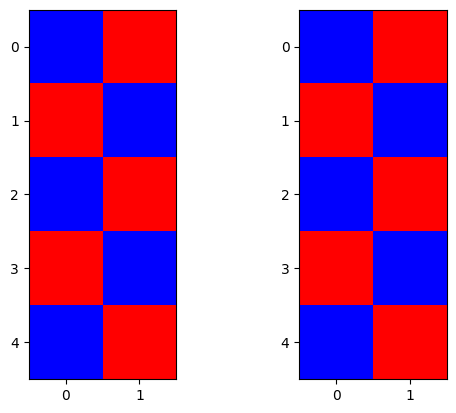

In [153]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(y[:5],cmap='bwr')
ax[1].imshow(soft(net(x[:5])).data,cmap='bwr')

# Embedding Layer

## Motive

`-` 결국 최종적으로는 아래와 같은 맵핑방식이 확장성이 있어보인다.

In [154]:
mapping = {'a':[1,0,0],'b':[0,1,0],'c':[0,0,1]} # 원핫인코딩 방식 

`-` 그런데 매번 $X$를 원핫 인코딩하고 Linear 변환하는 것이 번거로움

*  torch.nn.EmbeddingLayear가 이 역할을 대신해줌

In [155]:
mapping = {'a':0,'b':1,'c':2}
x = torch.tensor(f(list('abc')*100,mapping))
y = torch.tensor(f(list('bca')*100,mapping))
x[:5],y[:5]

(tensor([0, 1, 2, 0, 1]), tensor([1, 2, 0, 1, 2]))

In [156]:
torch.manual_seed(202150256)
ebdd = torch.nn.Embedding(num_embeddings=3,embedding_dim=1)

In [157]:
ebdd(x)[:5]

tensor([[-1.0770],
        [-0.2042],
        [ 1.3288],
        [-1.0770],
        [-0.2042]], grad_fn=<SliceBackward0>)

`-` 그런데 사실 언뜻보면 아래의 linr 함수와 역할의 차이가 없어보인다.

In [158]:
torch.manual_seed(202150256)
linr = torch.nn.Linear(in_features=1,out_features=1)

In [159]:
linr(x.float().reshape(-1,1))[:5]

tensor([[-0.0483],
        [-0.9158],
        [-1.7834],
        [-0.0483],
        [-0.9158]], grad_fn=<SliceBackward0>)

`-` 차이점 : 파라미터수에 차이가 있다.

In [160]:
ebdd.weight

Parameter containing:
tensor([[-1.0770],
        [-0.2042],
        [ 1.3288]], requires_grad=True)

In [161]:
linr.weight, linr.bias

(Parameter containing:
 tensor([[-0.8675]], requires_grad=True),
 Parameter containing:
 tensor([-0.0483], requires_grad=True))

##  연습 (ab문제 소프트맥스로 확장한 것 다시 풀이)

`-` 맵핑

In [162]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))
x[:5],y[:5]

(tensor([0, 1, 0, 1, 0]), tensor([1, 0, 1, 0, 1]))

`-`  torch.nn.Embedding 을 넣은 네트워크

In [163]:
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=2,embedding_dim=1),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1,out_features=2)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

`-` 학습

In [164]:
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

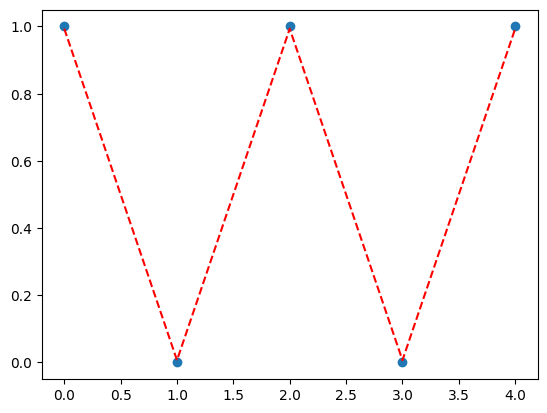

In [165]:
plt.plot(y[:5],'o')
plt.plot(soft(net(x[:5]))[:,1].data,'--r')

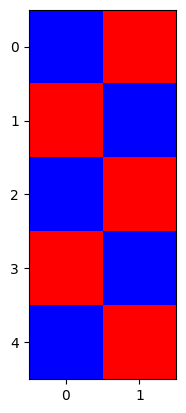

In [170]:
plt.imshow(soft(net(x[:5])).data,cmap='bwr')

In [173]:
y[:5]

tensor([1, 0, 1, 0, 1])

In [174]:
soft(net(x[:5]))

tensor([[0.0067, 0.9933],
        [0.9933, 0.0067],
        [0.0067, 0.9933],
        [0.9933, 0.0067],
        [0.0067, 0.9933]], grad_fn=<SoftmaxBackward0>)